In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from codecarbon import EmissionsTracker
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df = pd.read_csv('./dataset.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145139 entries, 0 to 145138
Data columns (total 20 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   DATA                                                   145139 non-null  object 
 1   HORA                                                   145139 non-null  object 
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       145139 non-null  float64
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  145139 non-null  float64
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        145139 non-null  float64
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       145139 non-null  float64
 6   RADIACAO GLOBAL (KJ/m²)                                145139 non-null  float64
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           145139 non-null  float64
 8   TEMPERATURA DO PONTO DE ORVALHO (°

In [3]:
df.set_index('timestamp')
df = df.drop(columns=['DATA', 'HORA'], axis=1)

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['second'] = df['timestamp'].dt.second

input_data = df.drop([
    'timestamp',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'], axis=1)
targets = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].values
T = 20                   
D = input_data.shape[1] 
N = len(input_data) - T

In [5]:
#Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])

# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])

# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [6]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to("cpu")
    c0 = torch.zeros(self.L, X.size(0), self.M).to("cpu")

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [7]:
model = LSTM(input_dim=D, hidden_dim=256, layer_dim=2, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
def train(model, learning_rate, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{epochs}] — Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses

In [9]:
def return_rmse(model, X_test, y_test):
    model.eval()
    device = next(model.parameters()).device
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_pred = model(X_test)

    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.cpu().numpy().flatten()

    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    return rmse

In [10]:
tracker = EmissionsTracker(
    project_name="temperature 0704",
    output_file='./emissions/temp_lstm.csv',
    log_level = "critical"
)

tracker.start()

train_losses, test_losses = train(
    model,
    learning_rate=0.001,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epochs=25,
    batch_size=64
)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 10:12:59] Multiple instances of codecarbon are allowed to run at the same time.
                                                                                       

Epoch [1/25] — Train Loss: 15.2511, Test Loss: 8.8853


Epoch [2/25] — Train Loss: 5.9207, Test Loss: 0.6720


Epoch [3/25] — Train Loss: 0.7050, Test Loss: 0.7267


Epoch [4/25] — Train Loss: 0.6834, Test Loss: 0.6477


Epoch [5/25] — Train Loss: 0.6726, Test Loss: 0.6583


Epoch [6/25] — Train Loss: 0.6578, Test Loss: 0.6039


Epoch [7/25] — Train Loss: 0.6532, Test Loss: 0.6219


Epoch [8/25] — Train Loss: 0.6441, Test Loss: 0.5955


Epoch [9/25] — Train Loss: 0.6369, Test Loss: 0.6384


Epoch [10/25] — Train Loss: 0.6307, Test Loss: 0.6562


Epoch [11/25] — Train Loss: 0.6223, Test Loss: 0.6398


Epoch [12/25] — Train Loss: 0.6193, Test Loss: 0.6129


Epoch [13/25] — Train Loss: 0.6271, Test Loss: 0.6058


Epoch [14/25] — Train Loss: 0.6061, Test Loss: 0.6176


Epoch [15/25] — Train Loss: 0.5992, Test Loss: 0.6887


Epoch [16/25] — Train Loss: 0.5956, Test Loss: 0.6116


Epoch [17/25] — Train Loss: 0.5945, Test Loss: 0.6188


Epoch [18/25] — Train Loss: 0.5880, Test Loss: 0.6113


Epoch [19/25] — Train Loss: 0.5823, Test Loss: 0.6218


Epoch [20/25] — Train Loss: 0.5768, Test Loss: 0.6185


Epoch [21/25] — Train Loss: 0.5706, Test Loss: 0.6523


Epoch [22/25] — Train Loss: 0.5634, Test Loss: 0.6240


Epoch [23/25] — Train Loss: 0.5564, Test Loss: 0.6367


Epoch [24/25] — Train Loss: 0.5458, Test Loss: 0.6843


Epoch [25/25] — Train Loss: 0.5393, Test Loss: 0.6425
emissions=0.0019131144778107225


In [11]:
def plot_dispersion(model, X_test, y_test):
    model.eval()
    device = next(model.parameters()).device  # Get the model's device (CPU or CUDA)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_pred = model(X_test)

    # Convert tensors to NumPy arrays for plotting
    y_true_np = y_test.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true_np, y_pred_np, alpha=0.7, color='blue')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Dispersion Plot: True vs Predicted')
    plt.grid(True)
    plt.plot([y_true_np.min(), y_true_np.max()], [y_true_np.min(), y_true_np.max()], 'r--')  # Ideal line
    plt.tight_layout()
    plt.savefig('./lstm_emissions/dispersao_temp.png')
    plt.show()

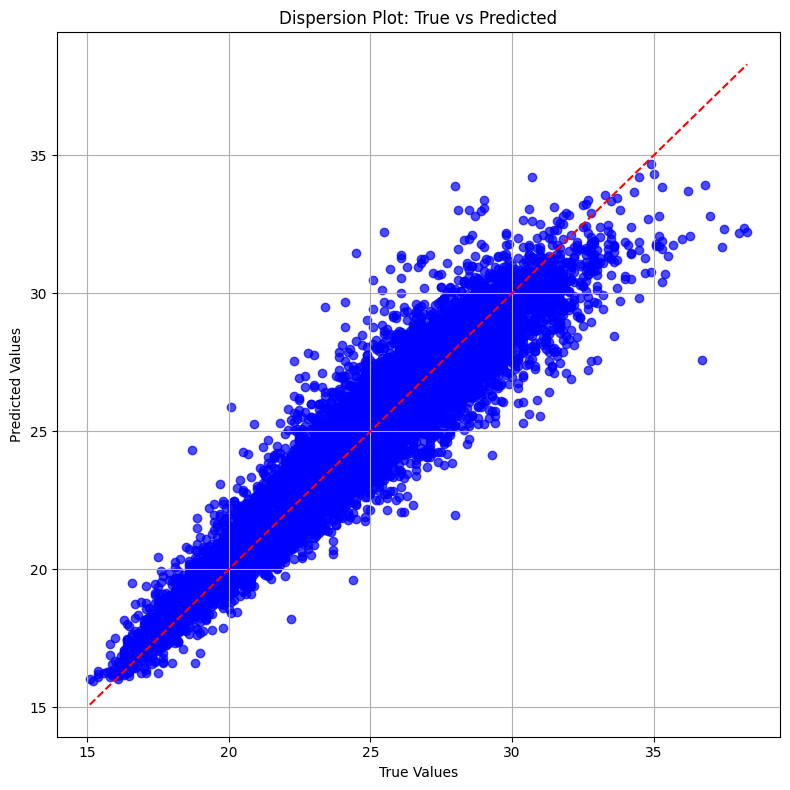

In [12]:
plot_dispersion(model, X_test, y_test)

In [13]:
def plot_real_vs_predicted(model, X_test, y_test):
    model.eval()
    device = next(model.parameters()).device 
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_pred = model(X_test)

    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.cpu().numpy().flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(y_true_np, label='Real', linewidth=2)
    plt.plot(y_pred_np, label='Predicted', linewidth=2)
    plt.title('Real vs Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

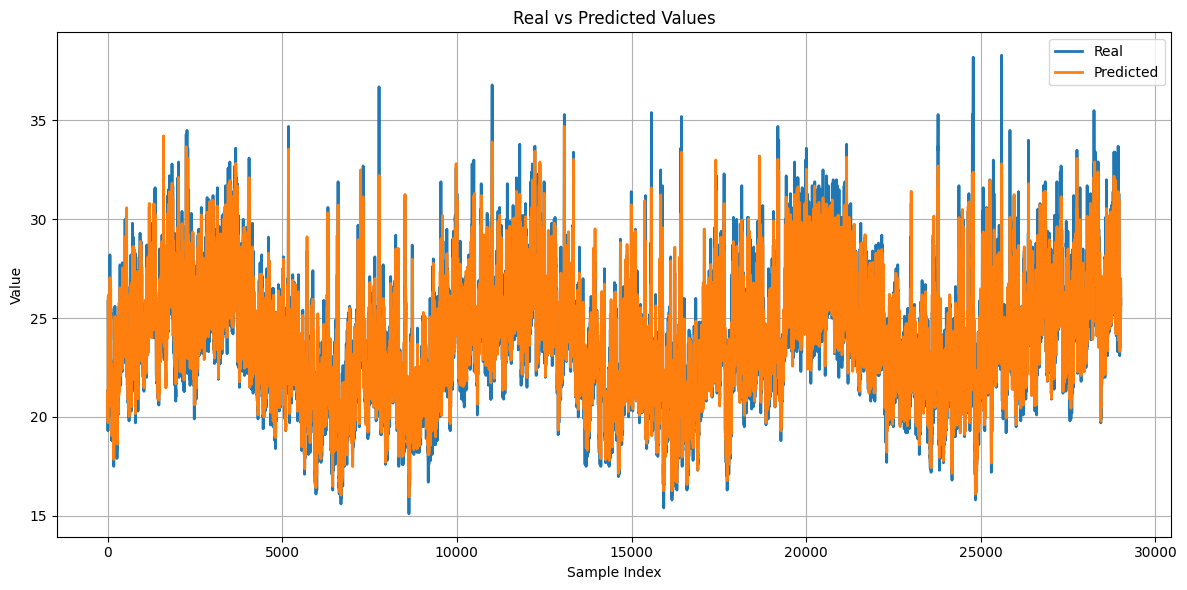

In [14]:
plot_real_vs_predicted(model, X_test, y_test)

In [15]:
def print_rmse(model, X_test, y_test):
    model.eval()
    device = next(model.parameters()).device
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_pred = model(X_test)

    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.cpu().numpy().flatten()

    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    print(f"RMSE: {rmse:.4f}")

In [16]:
return_rmse(model, X_test, y_test)

np.float64(0.801540926220967)

In [18]:
def plot_lstm_prediction_over_time(model, X_test, y_test, timestamps, start_date=None, end_date=None, save=False):
    model.eval()
    device = next(model.parameters()).device

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_pred = model(X_test)

    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.cpu().numpy().flatten()
    timestamps = pd.to_datetime(timestamp)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_true_np,
        'Predicted': y_pred_np
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('LSTM: Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(save)

    plt.show()

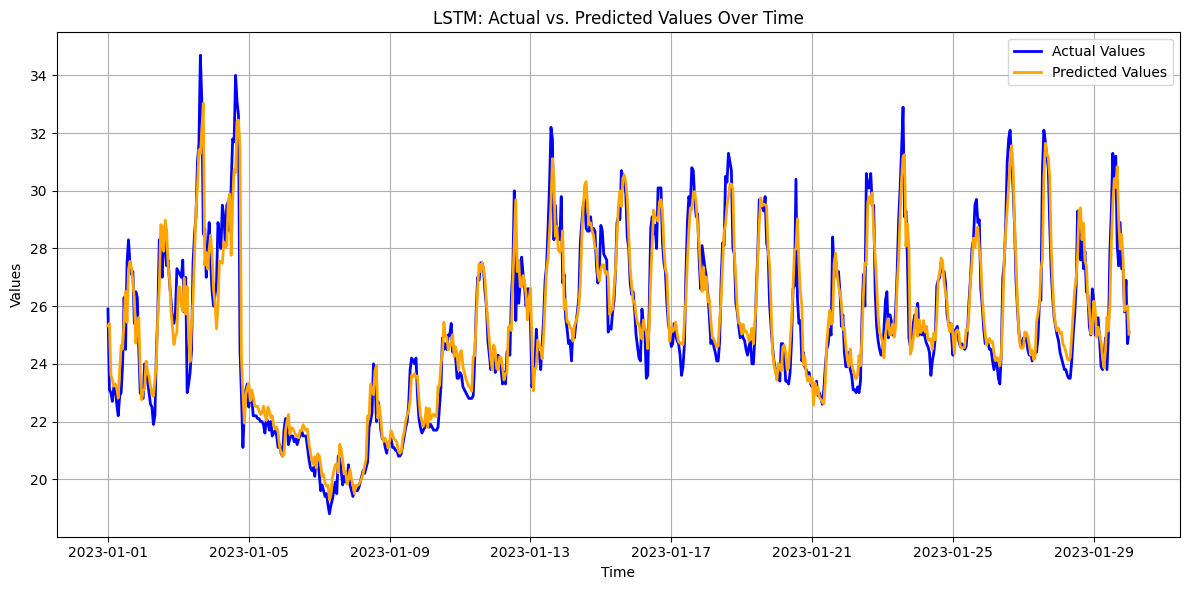

In [25]:
start_date = "2023-01-01"
end_date = "2023-01-30"

timestamps = pd.to_datetime(df['timestamp'])
timestamps_for_plot = timestamps[T:T + N]
timestamps_test = timestamps_for_plot[train_size:]

plot_lstm_prediction_over_time(model, X_test, y_test, timestamps_test,start_date, end_date, save='./lstm_images/lstm_temp_rvp.png')